* **Práctica 1: Introducción a la segmentación semántica: preprocesado, métricas e inferencia.**
* **Práctica 2: Implementación y entrenamiento de redes UNET para un problema binario (dataset carvana)**
* **Práctica 3: Implementación y entrenamiento de redes FCN para un problema multiclase (dataset cityscapes)**

# **Introducción a la segmentación semántica en PyTorch: Practica 1**

## **Máster IA3: Aprendizaje Profundo II**

### *Antonio Martínez González (antonio.martinez-gonzalez@uv.es)*

### Ejecución en Google Colab con CPU ###

# **Introducción**



En un problema clásico de segmentación de imágenes existen dos principales distinciones que determinan la dinámica de las arquitecturas propuestas:
* Número de clases
  * Segmentación binaria
  * Segmentación multiclase
* Diferenciación de instancias en una misma clase
  * **Segmentación semántica**
  * **Segmentación por instancias**

A lo largo de esta práctica nos centraremos en entender en profundidad el funcionamiento de las etapas de inferencia y evaluación sobre un problema de segmentación semántica multiclase, con especial hincapié en la **estructura y tratamiento de los datos** y **las métricas comúnmente utilizadas**.

La segmentación semántica en imágenes se considera como un problema de aprendizaje supervisado, donde cada entrada es una imágen, habitualmente formada por tres canales (RGB) y codificada como un array 3D. Cada elemento de la entrada se corresponde con un el nivel de intensidad del pixel en cuestión, normalmente representado como un número entero positivo con una profundidad de 8 bits (el tipo de dato se suele abreviar como *uint8*, en referencia a *unsigned 8-bit integer*), lo que equivale a $2^{8}=256$ niveles de intensidad diferentes.

![picture1](https://www.researchgate.net/publication/315881952/figure/fig5/AS:667673876779033@1536197265755/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle.jpg)

*Una de las imágenes de entrada del dataset Cityscapes (https://www.cityscapes-dataset.com/)*


Al contrario que en un problema típico de clasificación de imágenes, donde se asigna una única etiqueta a la imágen de entrada (la clase predicha), en un problema de segmentación semántica el objetivo principal consiste en asignar una etiqueta a cada pixel (*pixel by pixel classification*). Asumiendo un setting binario, se tendrían las siguientes clases:

* **Clase 1 (+): objeto de interés** (por ejemplo un coche, una hoja o una persona)
* **Clase 0 (-): background** (engloba todo lo que no se corresponde con el objeto de interés)


![picture2](https://www.mdpi.com/applsci/applsci-13-01493/article_deploy/html/images/applsci-13-01493-g007-550.jpg)

*Fila superior: entradas del modelo de segmentación, Fila inferior: salida esperada (ground truth). Dataset Cityscapes*

El ground truth o target es un array 2D, también llamado mapa de segmentación o más informalmente máscara, donde cada entrada contiene la etiqueta asociada al pixel en cuestión. Cada etiqueta se suele codificar empleando el índice asociado a la clase (comenzando desde cero).

En un setting multiclase con 2 objetos de interés y una clase de referencia, un ejemplo de máscara para una imágen de tamaño $3\times3$ sería el siguiente array:

$$
\begin{align}
\begin{pmatrix}
0 & 2 & 1 \\
2 & 0 & 0 \\
1 & 0 & 0
\end{pmatrix}
\end{align}
$$

Es decir, se tendrían una clase por cada entidad de interés y una clase de referencia que agrupa todo lo demás (backround). La representación de la máscara se realiza asignando un número entero a cada pixel, a corresponderse con el código de la categoría asociada.


In [ ]:
# Importacion de librerias
import torch
import torchvision
from matplotlib import pyplot as plt
import os
import numpy as np
import PIL


# **Dataset**



El dataset escogido para el desarrollo de esta práctica es el famoso [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/), utilizado como benchmark en gran cantidad de proyectos y artículos académicos. Está formado por 12k imágenes con sus correspondientes máscaras, dividas en dos conjuntos: entrenamiento y validación. Dispone de 21 categorías (20 objetos de interés maś la categoría de referencia o *background*).

La siguiente lista indica el código y nombre asociado a cada categoría:

* 0: background
* 1: aeroplane
* 2: bicycle
* 3: bird
* 4: boat
* 5: bottle
* 6: bus
* 7: car
* 8: cat
* 9: chair
* 10: cow
* 11: diningtable
* 12: dog
* 13: horse
* 14: motorbike
* 15: person
* 16: potted plant
* 17: sheep
* 18: sofa
* 19: train
* 20: tv/monitor

Cada categoría dispone de un triplete RGB asociado con el objetivo de disponer de una visualización estandarizada de los mapas de segmentación.


In [ ]:
# Tripletes RGB asociados a cada clase (primer elemento se corresponde con la clase de índice 0 y así sucesivamente)
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

In [ ]:
# Nombre asociado a cada clase (mismo órden que en VOC_COLORMAP)
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [ ]:
# mapeado código:triplete_rgb (se utilizará para reconstruir el mapa de segmentacion como imagen en color)
VOC_COLORMAP_ = dict(zip(list(range(len(VOC_CLASSES))), VOC_COLORMAP))
VOC_COLORMAP_

{0: [0, 0, 0],
 1: [128, 0, 0],
 2: [0, 128, 0],
 3: [128, 128, 0],
 4: [0, 0, 128],
 5: [128, 0, 128],
 6: [0, 128, 128],
 7: [128, 128, 128],
 8: [64, 0, 0],
 9: [192, 0, 0],
 10: [64, 128, 0],
 11: [192, 128, 0],
 12: [64, 0, 128],
 13: [192, 0, 128],
 14: [64, 128, 128],
 15: [192, 128, 128],
 16: [0, 64, 0],
 17: [128, 64, 0],
 18: [0, 192, 0],
 19: [128, 192, 0],
 20: [0, 64, 128]}

In [ ]:
# Descarga de los conjuntos de entrenamiento y validación del dataset PASCALVOC (version 2012) a través de la API de PyTorch
voc_dataset = torchvision.datasets.VOCSegmentation(root="./PASCALvoc2012", year="2012", image_set="train", download=True)

100%|██████████| 1999639040/1999639040 [01:02<00:00, 32086070.26it/s]


Extracting ./PASCALvoc2012/VOCtrainval_11-May-2012.tar to ./PASCALvoc2012


In [ ]:
import torchvision

Mediante la celda anterior los conjuntos de entrenamiento y validación del dataset *PASCAL VOC 2012* son descargados y almacenados como fichero con extensión *tar* en el directorio local especificado en el parámetro *root*.



In [ ]:
os.listdir()

['.config', 'PASCALvoc2012', 'sample_data']

In [ ]:
os.listdir("PASCALvoc2012")

['VOCtrainval_11-May-2012.tar', 'VOCdevkit']

In [ ]:
type(voc_dataset)

torchvision.datasets.voc.VOCSegmentation

Sin embargo en la práctica no es necesario acceder a tal fichero, ya que el objeto devuelto por la función *VOCSegmentation* es una instancia de la clase *voc_dataset*, la cual a su vez hereda la funcionalidad de la clase [torch.utils.data.Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) (contenedor general de datos en PyTorch).

* https://pytorch.org/vision/stable/_modules/torchvision/datasets/voc.html#VOCDetection (VOCSegmentation hereda de VisionDataset)
* https://pytorch.org/vision/main/_modules/torchvision/datasets/vision.html#VisionDataset (VisionDataset hereda de torch.utils.data.Dataset)

En definitiva, podemos acceder a cada muestra (par formado por la imágen de entrada y la máscara verdadera o ground truth) a través del operador de indexado (o alternativamente mediante el método *\__getitem__*):

In [ ]:
img0, target0 = voc_dataset.__getitem__(0)

In [ ]:
img0, target0 = voc_dataset[0] # Primera muestra del dataset PASCAL VOC

In [ ]:
type(img0)

PIL.Image.Image

In [ ]:
type(target0)

PIL.PngImagePlugin.PngImageFile

Los objetos devueltos son instancias de la clase *Image* de la librería *PIL* (estándard para la importación y exportación de imaǵenes en Python).

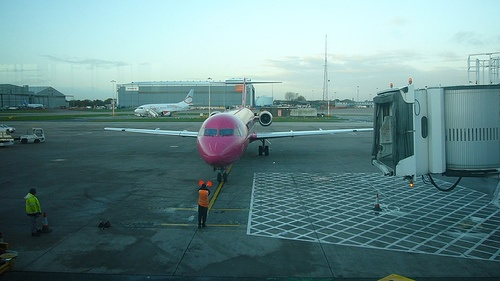

In [ ]:
img0 # Jupyter automáticamente aplica las conversiones necesarias para mostrar por pantalla la imágen

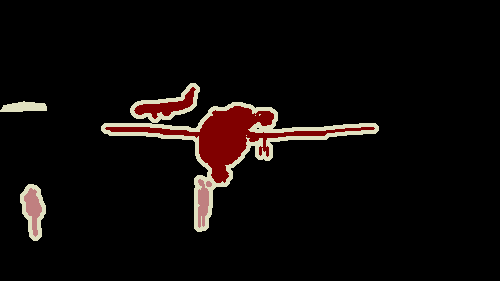

In [ ]:
target0 # Lo mismo ocurre con la máscara, pero con ciertas consideraciones extra (la imagen y la máscara se corresponden con diferentes de la librería PIL)

In [ ]:
img1, target1 = voc_dataset[1] # Segunda muestra del dataset

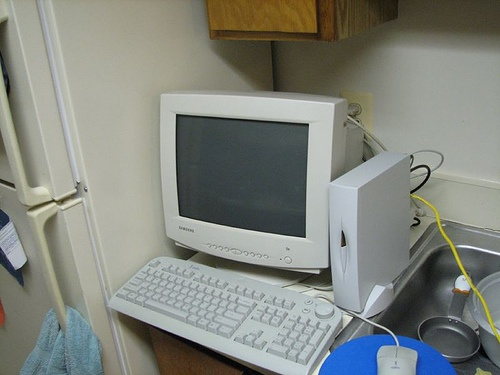

In [ ]:
img1

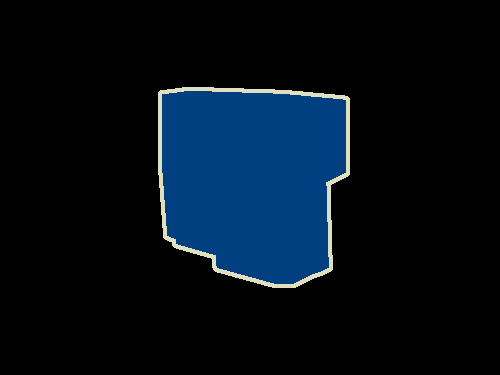

In [ ]:
target1



Los contornos que aparecen en las máscaras son artificiales, es decir, no se utilizan ni en el entrenamiento ni en la evaluación de los modelos. Más adelante se implementará el tratamiento de estos valores especiales.

Antes de implementar el preprocesado comentaremos el modelo escogido para el desarrollo de esta práctica introductoria.


# **Modelo**



La arquitectura escogida consiste en el modelo convolucional ***DeepLabV3* con *ResNet101* como *backbone***:

* Paper: *Rethinking Atrous Convolution for Semantic Image Segmentation* (https://arxiv.org/abs/1706.05587)
* Repositorio Github: https://github.com/leimao/DeepLab-V3
* Documentación de PyTorch: https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_resnet101.html


![picture](https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3-complete_architecture.png)

* *backbone: red neuronal localizada al incio de DeepLabV3 que extrae las características (feature maps) para las capas posteriores*

In [ ]:
# Descarga del modelo DeeplabV3 con ResNet101 como backbone a través de la API torchvision
model = torchvision.models.segmentation.deeplabv3_resnet101(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 113MB/s]


In [ ]:
type(model)

torchvision.models.segmentation.deeplabv3.DeepLabV3

In [ ]:
next(model.parameters()).dtype # Tipo de dato de los parámetros

torch.float32

In [ ]:
def prin_n_params(pytorch_model):

  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

  print(f"Trainable parameters: {trainable_params}")
  print(f"Non-trainable parameters: {non_trainable_params}")
  print(f"Total parameters: {trainable_params + non_trainable_params}")

In [ ]:
prin_n_params(model)

Trainable parameters: 60996202
Non-trainable parameters: 0
Total parameters: 60996202


In [ ]:
60996202 * (32/8) / 1024**2 # calculo del tamaño del modelo en Mb (asume que el tipo de dato de los parámetros es float32)

232.68204498291016

In [ ]:
# Pasar el modelo a 'evaluation mode' (necesario para la inferencia; las capas BatchNorm se comportan de forma distinta en entrenamiento e inferencia)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# **Importación y preprocesado**



Antes de calcular y visualizar las predicciones del modelo DeepLabV3 hemos de entender la estructura de los datos de entrada, adaptarla de modo que sea compatible con la API de evaluación de modelos en *PyTorch* y aplicar las estrategia de preprocesado pertinentes.

El pipeline habitual en este tipo de problemas en lo que respecta a las etapas de importación y preprocesado es el siguiente:

*ruta del archivo* -> *objeto PIL* -> *objeto np.ndarray* -> *preprocesado* -> *conversion a tensor*

Aplicado tanto a la imágen de entrada como a la máscara de salida.

Primero mostraremos paso a paso la implementación de todas las etapas para una instancia particular del dataset y luego se automatizará todo el proceso de forma eficiente.

In [ ]:
img0, mask0 = voc_dataset[0] # Primera muestra del dataset PASCAL VOC

In [ ]:
img0_arr = np.array(img0, dtype=np.float32) # conversion de objeto PIL a np.ndarray
img0_arr.shape

(281, 500, 3)

Como podemos observar la imágen de entrada consiste en un array con shape (heigth, width, n_channels) compuesto por tres canales (RGB).

Por lo tanto, previo a la conversión a tensor de PyTorch es necesario adaptar la dimensionalidad de la imágen de entrada de modo que sea compatible con el formato de datos 3D por defecto en PyTorch, formato conocido como **Channels First** (primero la dimensión que contiene los canales, después altura y por último anchura).

*Tensorflow utiliza el formato Channels Last by default*

Para ello podemos emplear la función *np.transpose*:

In [ ]:
img0_arr = np.transpose(img0_arr, (2,0,1)) # PyTorch by default utiliza el formato Channels First para los datos 3D
img0_arr.shape

(3, 281, 500)

Tras la adaptación podemos convertir la imágen directamente a objetio de tipo torch.Tensor a través de la función torch.from_numpy:

In [ ]:
img0_torch = torch.from_numpy(img0_arr) # Conversion a torch.tensor
img0_torch = img0_torch.unsqueeze(0) # Añadir el batch dimension (necesario para la inferencia!)
img0_torch.shape

torch.Size([1, 3, 281, 500])

Otra opción sería convertir directamente a torch.tensor y adaptar las dimensiones mediante utilidades de PyTorch.

In [ ]:
img0_arr = np.array(img0, dtype=np.float32) # Conversion a np.array
img0_torch = torch.from_numpy(img0_arr) # Conversión a torch.Tensor
img0_torch.shape

torch.Size([281, 500, 3])

In [ ]:
img0_torch = torch.transpose(img0_torch, 0, 2) # swapping entre la primera y última dimensión
img0_torch = torch.transpose(img0_torch, 1, 2) # swapping entre la segunda y tercera dimensión para recuperar el formato height x width
img0_torch = img0_torch.unsqueeze(0) # Añadir el batch dimension
img0_torch.shape

torch.Size([1, 3, 281, 500])

O utilizar utilidades de numpy sobre tensores de PyTorch: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#bridge-with-numpy


In [ ]:
img0_torch = torch.from_numpy(img0_arr)
img0_torch = np.transpose(img0_torch, (2,0,1))
img0_torch = img0_torch.unsqueeze(0)
img0_torch.shape

torch.Size([1, 3, 281, 500])

En cualquier caso, la imágen de entrada convertida a tensor tiene la siguiente estructura:

In [ ]:
img0_torch

tensor([[[[131., 131., 131.,  ..., 182., 182., 182.],
          [132., 132., 133.,  ..., 183., 183., 182.],
          [133., 133., 134.,  ..., 183., 183., 182.],
          ...,
          [  6.,   5.,   7.,  ...,  16.,  16.,  16.],
          [  5.,   9.,  12.,  ...,  16.,  17.,  17.],
          [  5.,   6.,  10.,  ...,  16.,  12.,  17.]],

         [[193., 193., 193.,  ..., 232., 232., 232.],
          [194., 194., 195.,  ..., 233., 233., 232.],
          [195., 195., 196.,  ..., 233., 233., 232.],
          ...,
          [ 15.,  14.,  13.,  ...,  34.,  34.,  34.],
          [ 14.,  18.,  17.,  ...,  34.,  35.,  35.],
          [ 15.,  16.,  18.,  ...,  33.,  29.,  34.]],

         [[208., 208., 208.,  ..., 241., 241., 241.],
          [209., 209., 210.,  ..., 242., 242., 241.],
          [210., 210., 211.,  ..., 242., 242., 241.],
          ...,
          [ 14.,  13.,  13.,  ...,  38.,  38.,  38.],
          [ 13.,  17.,  20.,  ...,  38.,  39.,  39.],
          [ 14.,  15.,  20.,  ...

Notar como las entradas de la imágen se corresponden con números enteros en el rango $[0,255]$. En la práctica es común dividir cada entrada por el nivel de intensidad máximo ($2^{8}-1=255$, ya que el tipo de dato original es uint8) con el objetivo de que la distribución de los datos se encuentre contenida en un intervalo de amplitud relativamente pequeña ($[0,1]$ en este caso), proceso tamibén conocido como de escalado o normalización de los datos.

Se engloba dentro de la etapa de preprocesado y supone una mayor estabilidad en el entrenamiento de los modelos neuronales, sobre todo aquellos formados por muchas capas.

In [ ]:
img0_torch = img0_torch / 255.0 # escalado
img0_torch

tensor([[[[0.5137, 0.5137, 0.5137,  ..., 0.7137, 0.7137, 0.7137],
          [0.5176, 0.5176, 0.5216,  ..., 0.7176, 0.7176, 0.7137],
          [0.5216, 0.5216, 0.5255,  ..., 0.7176, 0.7176, 0.7137],
          ...,
          [0.0235, 0.0196, 0.0275,  ..., 0.0627, 0.0627, 0.0627],
          [0.0196, 0.0353, 0.0471,  ..., 0.0627, 0.0667, 0.0667],
          [0.0196, 0.0235, 0.0392,  ..., 0.0627, 0.0471, 0.0667]],

         [[0.7569, 0.7569, 0.7569,  ..., 0.9098, 0.9098, 0.9098],
          [0.7608, 0.7608, 0.7647,  ..., 0.9137, 0.9137, 0.9098],
          [0.7647, 0.7647, 0.7686,  ..., 0.9137, 0.9137, 0.9098],
          ...,
          [0.0588, 0.0549, 0.0510,  ..., 0.1333, 0.1333, 0.1333],
          [0.0549, 0.0706, 0.0667,  ..., 0.1333, 0.1373, 0.1373],
          [0.0588, 0.0627, 0.0706,  ..., 0.1294, 0.1137, 0.1333]],

         [[0.8157, 0.8157, 0.8157,  ..., 0.9451, 0.9451, 0.9451],
          [0.8196, 0.8196, 0.8235,  ..., 0.9490, 0.9490, 0.9451],
          [0.8235, 0.8235, 0.8275,  ..., 0

Es importante verificar que el tipo de los datos es float32, ya que es el utilizado en los pesos de la red neuronal (emplear diferentes profundidades supondria un proceso interno de conversión o casting, incrementando el coste computacional, además de que puede conllevar a inconsistencias e incluso errores).

In [ ]:
img0_torch.dtype

torch.float32

Adicionalmente, dado que el modelo DeepLabV3 en la etapa de preprocesado aplica estandarización de las imágenes de entrada según la media y desviación típica del dataset ImageNet (ya que utiliza como backbone un modelo pre-entrenado sobre ImageNet) es altamente recomendable aplicar dicha transformación.

De esta forma estamos modificando la distribución con el objetivo de asemejarla a la utilizada en la etapa de entrenamiento del modelo escogido.

En caso contrario, el rendimiento del modelo se vería afectado con casi total seguridad.

Para ello emplearemos la función [torchvision.transforms.Normalize](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)

In [ ]:
img0_torch = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img0_torch)
img0_torch

tensor([[[[ 0.1254,  0.1254,  0.1254,  ...,  0.9988,  0.9988,  0.9988],
          [ 0.1426,  0.1426,  0.1597,  ...,  1.0159,  1.0159,  0.9988],
          [ 0.1597,  0.1597,  0.1768,  ...,  1.0159,  1.0159,  0.9988],
          ...,
          [-2.0152, -2.0323, -1.9980,  ..., -1.8439, -1.8439, -1.8439],
          [-2.0323, -1.9638, -1.9124,  ..., -1.8439, -1.8268, -1.8268],
          [-2.0323, -2.0152, -1.9467,  ..., -1.8439, -1.9124, -1.8268]],

         [[ 1.3431,  1.3431,  1.3431,  ...,  2.0259,  2.0259,  2.0259],
          [ 1.3606,  1.3606,  1.3782,  ...,  2.0434,  2.0434,  2.0259],
          [ 1.3782,  1.3782,  1.3957,  ...,  2.0434,  2.0434,  2.0259],
          ...,
          [-1.7731, -1.7906, -1.8081,  ..., -1.4405, -1.4405, -1.4405],
          [-1.7906, -1.7206, -1.7381,  ..., -1.4405, -1.4230, -1.4230],
          [-1.7731, -1.7556, -1.7206,  ..., -1.4580, -1.5280, -1.4405]],

         [[ 1.8208,  1.8208,  1.8208,  ...,  2.3960,  2.3960,  2.3960],
          [ 1.8383,  1.8383,  

In [ ]:
# que ocurre si estandarizamos los datos sin antes aplicar nomalizacion?

El resultado de la celda anterior es un tensor válido, tanto a nivel de estructura como de distribución, para ser utilizado como entrada del modelo DeepLabV3.

In [ ]:
with torch.no_grad():
  prediction0 = model(img0_torch)

La siguiente función automatiza el proceso de importación y preprocesado descrito en las celdas anteriores:

In [ ]:
def loadAndPreprocessImg(pil_image):
  img = np.array(pil_image, dtype=np.float32) # conversion a np.array con tipo float32
  img = np.transpose(img, (2,0,1)) # Channels First !!
  img = torch.from_numpy(img) # Conversion a torch.tensor
  img = img.unsqueeze(0) # batch dimension
  img = img / 255.0 # escalado
  img = torchvision.transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])(img) # estandarizacion
  return img

In [ ]:
img0_torch = loadAndPreprocessImg(img0)
img0_torch

tensor([[[[ 0.1254,  0.1254,  0.1254,  ...,  0.9988,  0.9988,  0.9988],
          [ 0.1426,  0.1426,  0.1597,  ...,  1.0159,  1.0159,  0.9988],
          [ 0.1597,  0.1597,  0.1768,  ...,  1.0159,  1.0159,  0.9988],
          ...,
          [-2.0152, -2.0323, -1.9980,  ..., -1.8439, -1.8439, -1.8439],
          [-2.0323, -1.9638, -1.9124,  ..., -1.8439, -1.8268, -1.8268],
          [-2.0323, -2.0152, -1.9467,  ..., -1.8439, -1.9124, -1.8268]],

         [[ 1.3431,  1.3431,  1.3431,  ...,  2.0259,  2.0259,  2.0259],
          [ 1.3606,  1.3606,  1.3782,  ...,  2.0434,  2.0434,  2.0259],
          [ 1.3782,  1.3782,  1.3957,  ...,  2.0434,  2.0434,  2.0259],
          ...,
          [-1.7731, -1.7906, -1.8081,  ..., -1.4405, -1.4405, -1.4405],
          [-1.7906, -1.7206, -1.7381,  ..., -1.4405, -1.4230, -1.4230],
          [-1.7731, -1.7556, -1.7206,  ..., -1.4580, -1.5280, -1.4405]],

         [[ 1.8208,  1.8208,  1.8208,  ...,  2.3960,  2.3960,  2.3960],
          [ 1.8383,  1.8383,  

In [ ]:
def loadAndPreprocessImg(pil_image):
  """
  Preprocesa una imagen dada en formato PIL:
      - normalizacion al rango [0,1]
      - estandarizacion mediante la media y desviacion típica del dataset ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      - añadir la dimension 'batch'
  """
  img = pil_image
  transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),  # normalización a [0,1] y conversion a torch.Tensor
      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # estandarizacion
  ])
  img = transform(img).unsqueeze(0)
  return img

In [ ]:
img0_torch = loadAndPreprocessImg(img0)
img0_torch

tensor([[[[ 0.1254,  0.1254,  0.1254,  ...,  0.9988,  0.9988,  0.9988],
          [ 0.1426,  0.1426,  0.1597,  ...,  1.0159,  1.0159,  0.9988],
          [ 0.1597,  0.1597,  0.1768,  ...,  1.0159,  1.0159,  0.9988],
          ...,
          [-2.0152, -2.0323, -1.9980,  ..., -1.8439, -1.8439, -1.8439],
          [-2.0323, -1.9638, -1.9124,  ..., -1.8439, -1.8268, -1.8268],
          [-2.0323, -2.0152, -1.9467,  ..., -1.8439, -1.9124, -1.8268]],

         [[ 1.3431,  1.3431,  1.3431,  ...,  2.0259,  2.0259,  2.0259],
          [ 1.3606,  1.3606,  1.3782,  ...,  2.0434,  2.0434,  2.0259],
          [ 1.3782,  1.3782,  1.3957,  ...,  2.0434,  2.0434,  2.0259],
          ...,
          [-1.7731, -1.7906, -1.8081,  ..., -1.4405, -1.4405, -1.4405],
          [-1.7906, -1.7206, -1.7381,  ..., -1.4405, -1.4230, -1.4230],
          [-1.7731, -1.7556, -1.7206,  ..., -1.4580, -1.5280, -1.4405]],

         [[ 1.8208,  1.8208,  1.8208,  ...,  2.3960,  2.3960,  2.3960],
          [ 1.8383,  1.8383,  

In [ ]:
img0_torch.dtype

torch.float32

In [ ]:
def loadAndPreprocessImg(pil_image, transform=None):
  """
  Preprocesa una imagen dada en formato PIL.
  Args:
    - pil_image: imagen RGB como instancia de la clase PIL.Image
    - transform: callable que acepte una instancia de la clase PIL.Image y devuelva la imagen como torch.Tensor
  Returns:
    torch.Tensor
  El preprocesado debe de consistir de al menos las siguientes operaciones:
    - normalizacion a [0,1]
    - añadir la dimension batch
  """
  img = pil_image
  if transform:
    img = transform(img)
  else:
    img = np.array(img, dtype=np.float32)
    img = np.transpose(img, (2,0,1))
    img = img / 255.0
    img = torch.from_numpy(img)
  img = img.unsqueeze(0)
  return img

Llegado a este punto damos por cubierto la importación y preprocesado de la imágen de entrada del modelo de segmentación. Respecto a la máscara:


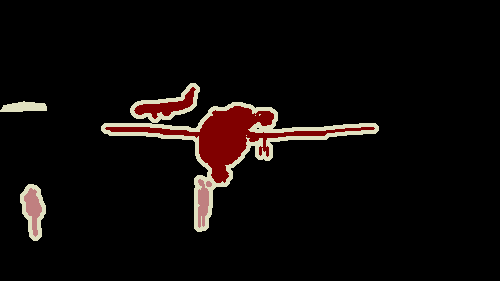

In [ ]:
target0

In [ ]:
mask0 = np.array(target0, dtype=np.float32)

In [ ]:
mask0.shape

(281, 500)

In [ ]:
mask0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
np.unique(mask0)

array([  0.,   1.,  15., 255.], dtype=float32)

Se trata de un array 2D compuesto por números enteros en el rango $[0,255]$. Mediante la función np.unique es posible comprobar como los únicos valores presentes para este muestra concreta son 0 (clase background o fondo), 1 (clase avión), 15 (clase persona) y 255 (valor especial empleado para delimitar el contorno de las instancias contenidas en la imágen).

Dado que el valor 255 no se corresponde con el índice de ninguna de las 21 clases del dataset PASCAL VOC, lo primero que haremos será fusionar estos valores con la clase 0 (backround).

Antes de ello es necesario asegurarse de que las operaciones que realizemos sobre las máscras no pueden introducir errores numéricos ya que la dinámica de entrenamiento es espcialmente sensible a este factor. Una forma correcta sería mediante operaciones de indexado con arrays booleanas y asignación.


In [ ]:
mask0[mask0 == 255.0] = 0.0

Continuando con el preprocesado de la máscara, una vez fusionados los valores de los contornos con la clase background faltaría la conversión a torch.Tensor.

In [ ]:
mask0 = np.array(target0, dtype=np.float32)
mask0[mask0 == 255.0] = 0.0
mask0_torch = torch.from_numpy(mask0)
mask0_torch = mask0_torch.unsqueeze(0)
mask0_torch.shape

torch.Size([1, 281, 500])

In [ ]:
def loadAndPreprocessMask(pil_mask, transform=None):
  """
  Preprocesa una mascara dada en formato PIL.
  Args:
    - pil_image: mascara Grayscale como instancia de la clase PIL.Image
    - transform: callable que acepte una instancia de la clase PIL.Image y devuelva la mascara como torch.Tensor
  Returns:
    torch.Tensor
  El preprocesado debe de consistir en al menos las siguientes operaciones:
    - fusionar el contorno con la clase background
    - conversion a torch.Tensor
    - añadir la dimension batch
  """
  mask = pil_mask
  if transform:
    mask = transform(mask)
  else:
    mask = np.array(mask, dtype=np.float32)
    mask[mask == 255.0] = 0.0
    mask = torch.from_numpy(mask)
  mask = mask.unsqueeze(0)
  return mask

¿que ocurre si realizamos la conversión a torch.Tensor mediante transformaciones de torchvision?

In [ ]:
transform = torchvision.transforms.Compose([
    # en la mascara no se debe aplicar ningun tipo de reescalado y/o normalizacion
    torchvision.transforms.ToTensor(),
])
mask0_torch = loadAndPreprocessMask(target0, transform=transform)
mask0_torch.shape

torch.Size([1, 1, 281, 500])

In [ ]:
np.unique(mask0_torch)

array([0.        , 0.00392157, 0.05882353, 1.        ], dtype=float32)

* El escalado automático cambia la distribución de las clases

* Se añade la dimensión de los canales

En ambos casos, las transformaciones no son necesarias además de que la primera imposibilitaría el entrenamiento de los modelos.

Afortunadamente existen librerías que tienen en cuenta estos factores. Una muy utilizada es [albumentations](https://albumentations.ai/).

* Mayor flexibilidad y eficiencia.
* Mayor funcionalidad (image augmentation)
* Integración en Keras y PyTorch
* Transformación simultanea y coherente de las entradas y salidas en problemas de computer vision, especialmente en problemas de segmentación de imágenes y detección de objetos.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 # El submodulo pytorch de albumentations hay que importarlo por separado!!

La transformación que engloba el preprocesado implementado en celdas anteriores se definiría de la siguiente forma:

In [ ]:
transform_A = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Conversion a np.array, normalizacion a [0,1] y estandarizacion
    ToTensorV2(), # Conversion a PyTorch tensor (respeta el formato channels first)
])

La forma de llamar a la función cambia en comparación con la librería torchvision. En un problema de segmentación semántica, cada parámetro que le pasemos debe de corresponderse con uno de los argumentos:
* image
* mask

Siendo posible especificar solo uno de ellos.

Al contrario que con torchvision.transforms la entrada debe de ser un objeto de tipo np.ndarray (albumentations está escrita *on top of numpy*, además de otras librerías como opencv)

In [ ]:
transformed = transform_A(
    image=np.array(img0, dtype=np.float32),
    mask=np.array(target0, dtype=np.float32))
type(transformed)

dict

El objeto devuelto es un diccionario con tantas claves como argumentos hallamos utilizado en la llamada (una clave para la imágen y otra clave para la máscara)

In [ ]:
transformed.keys()

dict_keys(['image', 'mask'])

In [ ]:
img0_torch = transformed["image"]
img0_torch.shape

torch.Size([3, 281, 500])

In [ ]:
img0_torch

tensor([[[ 0.1254,  0.1254,  0.1254,  ...,  0.9988,  0.9988,  0.9988],
         [ 0.1426,  0.1426,  0.1597,  ...,  1.0159,  1.0159,  0.9988],
         [ 0.1597,  0.1597,  0.1768,  ...,  1.0159,  1.0159,  0.9988],
         ...,
         [-2.0152, -2.0323, -1.9980,  ..., -1.8439, -1.8439, -1.8439],
         [-2.0323, -1.9638, -1.9124,  ..., -1.8439, -1.8268, -1.8268],
         [-2.0323, -2.0152, -1.9467,  ..., -1.8439, -1.9124, -1.8268]],

        [[ 1.3431,  1.3431,  1.3431,  ...,  2.0259,  2.0259,  2.0259],
         [ 1.3606,  1.3606,  1.3782,  ...,  2.0434,  2.0434,  2.0259],
         [ 1.3782,  1.3782,  1.3957,  ...,  2.0434,  2.0434,  2.0259],
         ...,
         [-1.7731, -1.7906, -1.8081,  ..., -1.4405, -1.4405, -1.4405],
         [-1.7906, -1.7206, -1.7381,  ..., -1.4405, -1.4230, -1.4230],
         [-1.7731, -1.7556, -1.7206,  ..., -1.4580, -1.5280, -1.4405]],

        [[ 1.8208,  1.8208,  1.8208,  ...,  2.3960,  2.3960,  2.3960],
         [ 1.8383,  1.8383,  1.8557,  ...,  2

In [ ]:
mask0_torch = transformed["mask"]
mask0_torch.shape

torch.Size([281, 500])

In [ ]:
np.unique(mask0_torch)

array([  0.,   1.,  15., 255.], dtype=float32)

**Bonus** : Crear transformaciones personalizadas mediante [albumentations](https://albumentations.ai/)

Por ejemplo, una tranformación que añada el batch dimension a un objeto torch.Tensor (necesariamente despues de aplicar ToTensorV2!)

In [ ]:
# Aplicable solo a imagenes
class AddBatchDim(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super(AddBatchDim, self).__init__(always_apply, p)

    def apply(self, image, **params):
        # Añadir una dimensión vacía en axis=0
        image = image.unsqueeze(0)
        return image

In [ ]:
# Aplicable a imagenes y mascaras
class DualAddBatchDim(A.DualTransform):
    def __init__(self, always_apply=True, p=1.0):
        super(DualAddBatchDim, self).__init__(always_apply, p)

    def apply(self, image, **params):
        # Añadir una dimensión vacía en axis=0
        image = image.unsqueeze(0)
        return image

    def apply_to_mask(self, mask, **params):
        # Añadir una dimensión vacía en axis=0 para la máscara
        mask = mask.unsqueeze(0)
        return mask

In [ ]:
transformed = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
    DualAddBatchDim(), # Importante añadir esta transformacion custom despues de la conversion a torch.tensor
])(image=np.array(img0, dtype=np.float32), mask=np.array(target0, dtype=np.float32))

In [ ]:
transformed["image"].shape

torch.Size([1, 3, 281, 500])

In [ ]:
transformed["mask"].shape

torch.Size([1, 281, 500])

**Ejercicio**: Crear una composición de la siguientes transformaciones utilizando la librería [albumentations](https://albumentations.ai/):

* Cambiar la altura a 100 px y la anchura a 200 px.

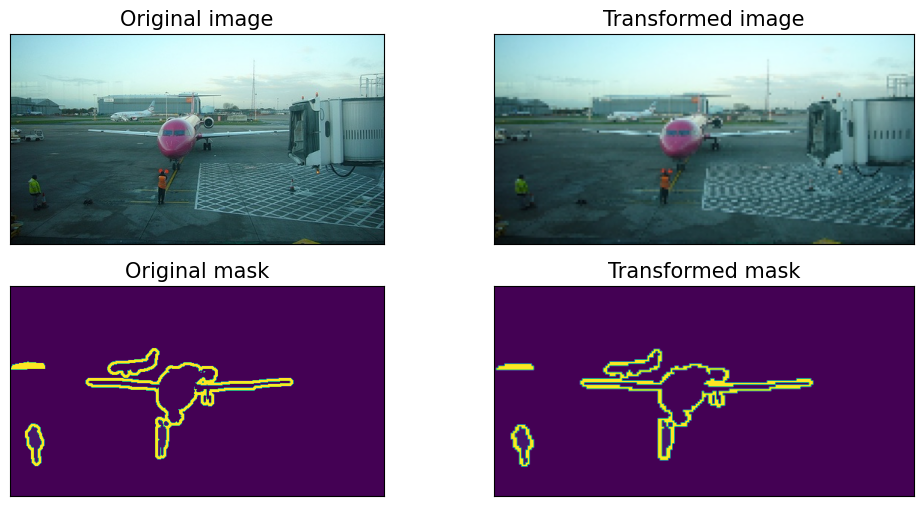


* Rotación mediante un número aleatorio del rango $[-40,40]$ con una probabilidad de 0.8.


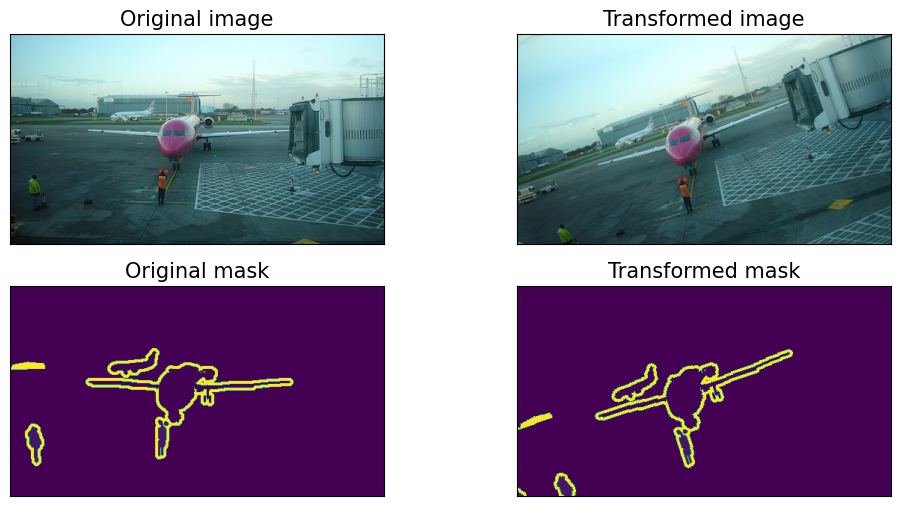

* Volteo (flip) horizonal con una probabilidad de 0.4


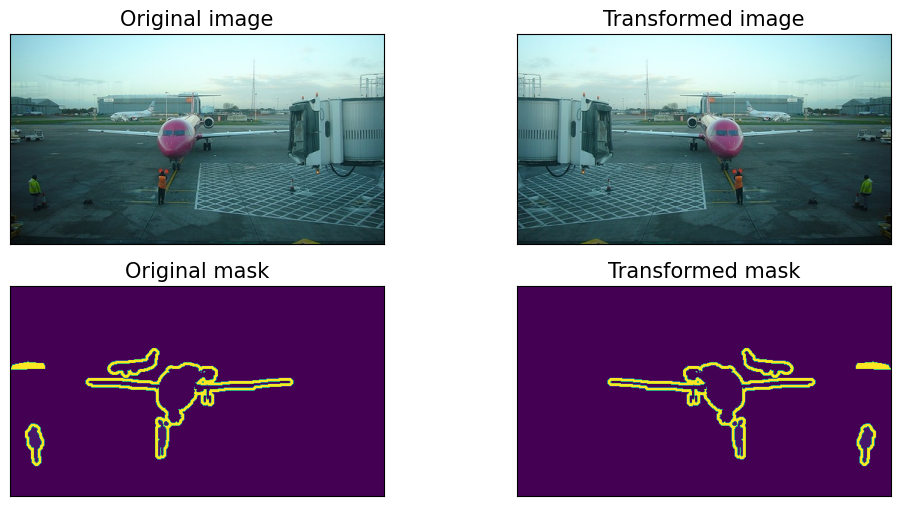

* Volteo (flip) vertical con una probabilidad de 0.2


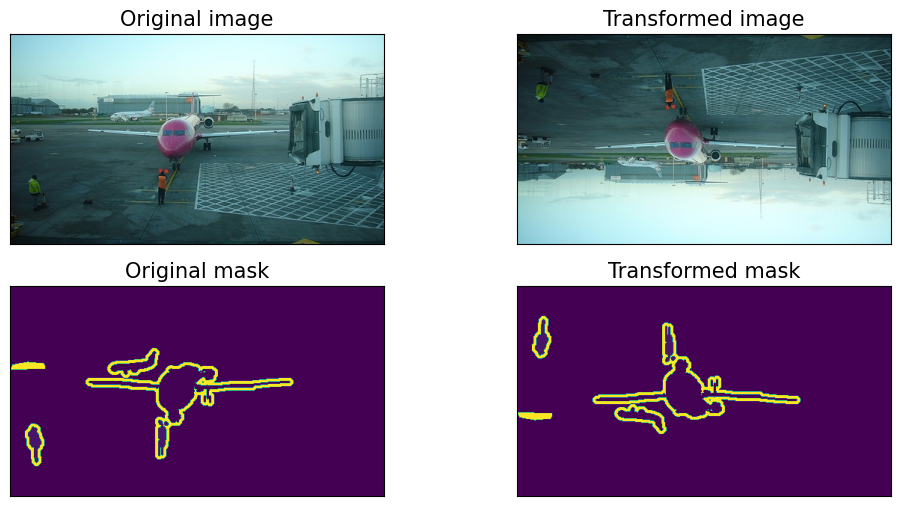

* Conversion a torch.Tensor con ToTensorV2

In [ ]:
transform_A = A.Compose([
    #resize
    #rotacion
    #volteo horizonal
    #volteo vertical
    ToTensorV2(),
])

Finalmente englobamos la etapa de preprocesado para imágen y máscara en una función:

In [ ]:
def loadAndPreprocessImgMask(pil_image, pil_mask, Atransform):

  img = np.array(pil_image, dtype=np.float32)
  mask = np.array(pil_mask, dtype=np.float32)

  transformed = Atransform(image=img, mask=mask)
  img = transformed["image"]
  mask = transformed["mask"]

  mask[mask == 255.0] = 0.0
  img = img.unsqueeze(0)
  mask = mask.unsqueeze(0)

  return img, mask

¿Que ocurre si la transformacion no utiliza albumentations.Normalize?

In [ ]:
transform_A = A.Compose([
    ToTensorV2()
])
img0_torch, mask0_torch = loadAndPreprocessImgMask(img0, target0, Atransform=transform_A)

In [ ]:
img0_torch

tensor([[[[131., 131., 131.,  ..., 182., 182., 182.],
          [132., 132., 133.,  ..., 183., 183., 182.],
          [133., 133., 134.,  ..., 183., 183., 182.],
          ...,
          [  6.,   5.,   7.,  ...,  16.,  16.,  16.],
          [  5.,   9.,  12.,  ...,  16.,  17.,  17.],
          [  5.,   6.,  10.,  ...,  16.,  12.,  17.]],

         [[193., 193., 193.,  ..., 232., 232., 232.],
          [194., 194., 195.,  ..., 233., 233., 232.],
          [195., 195., 196.,  ..., 233., 233., 232.],
          ...,
          [ 15.,  14.,  13.,  ...,  34.,  34.,  34.],
          [ 14.,  18.,  17.,  ...,  34.,  35.,  35.],
          [ 15.,  16.,  18.,  ...,  33.,  29.,  34.]],

         [[208., 208., 208.,  ..., 241., 241., 241.],
          [209., 209., 210.,  ..., 242., 242., 241.],
          [210., 210., 211.,  ..., 242., 242., 241.],
          ...,
          [ 14.,  13.,  13.,  ...,  38.,  38.,  38.],
          [ 13.,  17.,  20.,  ...,  38.,  39.,  39.],
          [ 14.,  15.,  20.,  ...

No aplica escalado automático, por lo que una solución es incorporarlo como parametro de control en la función *loadAndPreprocessImgMask*:

In [ ]:
def loadAndPreprocessImgMask(pil_image, pil_mask, Atransform=None, scale=False):

  img = np.array(pil_image, dtype=np.float32)
  mask = np.array(pil_mask, dtype=np.float32)

  transformed = Atransform(image=img, mask=mask)
  img = transformed["image"]
  mask = transformed["mask"]

  if scale:
    img = img / 255.0

  mask[mask == 255.0] = 0.0
  img = img.unsqueeze(0)
  mask = mask.unsqueeze(0)

  return img, mask

In [ ]:
transform_A = A.Compose([
    ToTensorV2()
])
img0_torch, mask0_torch = loadAndPreprocessImgMask(img0, target0, Atransform=transform_A, scale=True)
img0_torch

tensor([[[[0.5137, 0.5137, 0.5137,  ..., 0.7137, 0.7137, 0.7137],
          [0.5176, 0.5176, 0.5216,  ..., 0.7176, 0.7176, 0.7137],
          [0.5216, 0.5216, 0.5255,  ..., 0.7176, 0.7176, 0.7137],
          ...,
          [0.0235, 0.0196, 0.0275,  ..., 0.0627, 0.0627, 0.0627],
          [0.0196, 0.0353, 0.0471,  ..., 0.0627, 0.0667, 0.0667],
          [0.0196, 0.0235, 0.0392,  ..., 0.0627, 0.0471, 0.0667]],

         [[0.7569, 0.7569, 0.7569,  ..., 0.9098, 0.9098, 0.9098],
          [0.7608, 0.7608, 0.7647,  ..., 0.9137, 0.9137, 0.9098],
          [0.7647, 0.7647, 0.7686,  ..., 0.9137, 0.9137, 0.9098],
          ...,
          [0.0588, 0.0549, 0.0510,  ..., 0.1333, 0.1333, 0.1333],
          [0.0549, 0.0706, 0.0667,  ..., 0.1333, 0.1373, 0.1373],
          [0.0588, 0.0627, 0.0706,  ..., 0.1294, 0.1137, 0.1333]],

         [[0.8157, 0.8157, 0.8157,  ..., 0.9451, 0.9451, 0.9451],
          [0.8196, 0.8196, 0.8235,  ..., 0.9490, 0.9490, 0.9451],
          [0.8235, 0.8235, 0.8275,  ..., 0

In [ ]:
# Ejemplo de transformacion de albumentations utilizada en problemas reales
transform_complex = A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
    ], p=0.8)
transform = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, p=0.5),
])


# **Funciones de coste**



- **Cross Entropy** (binary / categorical): cuantifica el error del vector de probabilidades de pertenencia a cada clase mediante una función compatible (diferenciable en el sentido de *autograd*) con los algoritmos de descenso por gradiente.

Para una muestra se define de la siguiente forma:

$
H(y, \hat{y}) = -\sum_{c=1}^{C} y_c \log(\hat{y}_c) = -y_{p}\log(\hat{y}_{p})
$

donde:
* C es el número de clases
* y es un vector binario de longitud igual al número de clases tal que $y_c=1$ si c=p, donde p es el índice asociado a la clase verdadera y 0 en caso contrario
* $\hat{y}$ es el vector de probabilidades obtenido tras aplicar la función softmax sobre los logits (raw scores correspondientes a la última capa del modelo neuronal).

Cabe destacar que en las implementaciones comunes de la función categorical cross entropy el vector binario $y$ se programa como una función indicadora, por lo que en la práctica se utiliza como ground truth la propia máscara formada por números enteros (ausmiendo que cada clase se codifica como un número entero comenzando desde cero).

En el contexto actual, cada muestra sería un pixel por lo que el cálculo de la función cross-entropy consiste en promediar sobre el conjunto de pixeles que componen la imágen y después promediar sobre el conjunto de imaǵenes que componenen el mini-batch.

El principal problema que plantea es que trata a todas las clases por igual.

En PyTorch se encuentra disponible a través de la siguiente función:



In [ ]:
torch.nn.CrossEntropyLoss

torch.nn.modules.loss.CrossEntropyLoss


- [Lovasz-softmax loss](https://arxiv.org/pdf/1705.08790.pdf): surge como una versión suavizada de la métrica IoU (Intersection over Union, también llamada índice de Jaccard), la cual tiene en cuenta el desbalanceo entre clases.

Su definición es la siguiente:

$ L(\hat{y}, y) = \frac{1}{|C|} \sum_{c=1}^{|C|} \ell_{c}(\hat{y}^c, y^c) $

donde:
- $L(\hat{y}, y) $ es la función de coste Lovasz-Softmax entre las predicciones $ \hat{y} $ y las etiquetas verdaderas $ y $ o ground truth.
- $ \ell_{c}(\hat{y}^c, y^c) $ es la pérdida de Lovasz para la clase $c$
  - $ \hat{y}^c $ son las predicciones para la clase c.
  - $ y^c $ son las etiquetas verdaderas para la clase c.
  - $ \Delta J_i^c $ es la diferencia en el IoU para una instancia \( i \) en la clase c, calculada entre la predicción y la etiqueta verdadera.
  - $\phi(i)$ es una función que asigna un peso a la diferencia en el IoU de la instancia $i$ a partir del orden de los errores IoU de mayor a menor.
- $ \hat{y}^c $ y $ y^c $ son las predicciones (probabilidades) y las etiquetas verdaderas, respectivamente, para la clase $ c $.



<img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-06-27_at_4.27.39_PM.png" width=480>

([implementación en Pytorch y Tensorflow](https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py))


# **Métricas de evaluación**



Dado que el problema es de clasificación disponemos de todas las métricas derivadas de la matriz de confusión:

### **Accuracy**

En segmentación de imágenes, accuracy se interpreta como la proporción de pixeles correctamente clasificados.

Su definición es la siguiente: sean $A(i,j)$, $B(i,j)$ dos matrices 2D de tamaño $n\times m$.

$acc(A, B) = \frac{1}{n\cdot m}\sum_{i=0}^{n-1} \sum_{j=0}^{m-1}\mathbb{\chi}_{[A(i,j) = B(i,j)]}$

donde $\chi$ es la función característica (toma valor 1 si la condición del argumento es True y 0 en caso contrario)

**Ejercicio**: Implementar **en una línea** el cálculo de accuracy para matrices 3D con estructura (N, H, W), donde N es el número de muestras o batch size, H es la altura y W es la anchura. Definir una función que actue sobre np.ndarrays y otra que actue sobre objetos de tipo torch.Tensor.

*Pista: calcular el número de elementos coincidentes y dividir por el número total de elementos*

Para ello probar con los valores y_true, y_pred definidos en la siguiente celda:

In [ ]:
np.random.seed(123)
y_true = np.random.randint(0, 21, size=(4, 160, 240)).astype(np.float32)
y_pred = y_true.copy()
boolean = np.random.rand(4, 160, 240) < 0.3
y_pred[boolean] = 100

In [ ]:
y_true[0]

array([[13.,  2.,  2., ..., 12.,  8., 14.],
       [14., 16., 16., ...,  8.,  9., 15.],
       [10., 20., 13., ..., 17., 15.,  3.],
       ...,
       [ 0., 11., 16., ...,  0., 12., 19.],
       [16.,  0.,  6., ...,  7.,  4., 17.],
       [19.,  2.,  5., ...,  5., 16.,  0.]], dtype=float32)

In [ ]:
y_true.shape

(4, 160, 240)

In [ ]:
y_pred[0]

array([[ 13.,   2.,   2., ...,  12.,   8.,  14.],
       [ 14.,  16.,  16., ...,   8.,   9.,  15.],
       [ 10., 100.,  13., ...,  17., 100.,   3.],
       ...,
       [  0.,  11.,  16., ...,   0.,  12., 100.],
       [ 16.,   0.,   6., ..., 100., 100., 100.],
       [100., 100.,   5., ...,   5., 100.,   0.]], dtype=float32)

In [ ]:
y_pred.shape

(4, 160, 240)

El resultado debe ser similar al que se muestra en la siguiente celda (errores numéricos aparte):

In [ ]:
1 - np.sum(boolean) / boolean.size

0.7019270833333333

In [ ]:
def acc_numpy(y_true, y_pred): # Numpy
  return None

In [ ]:
acc_numpy(y_true, y_pred)

0.7019270833333333

In [ ]:
def acc_pytorch(y_true, y_pred): # PyTorch
  return None

In [ ]:
acc_pytorch(torch.from_numpy(y_true), torch.from_numpy(y_pred))

0.7019270658493042

La principal ventaja de accuracy está en la eficiencia de su cálculo y la simplicidad en la implementación, además de que la extensión a un setting multiclase es trivial.

Sin embargo el principal problema que presenta está en la falta de coherencia entre los valores proporiconados y la calidad de la clasificación al disponer de datasets altamente desbalanceados, algo muy común en problmemas de segmentación de imágenes (habitualmente los objetos de interés ocupan una pequeña proporción de la imágen).

En este sentido una métrica más robusta derivada de la matriz de confusión es el F1 score, también conocido como coeficiente DICE, pues tiene en cuenta los casos incorrectamente clasificados.

### **F1 score**

Se define como la media armónica entre la precisión ($\frac{TP}{TP+FP}=\frac{TP}{PP}$) y el recall ($\frac{TP}{TP+FN}=\frac{TP}{P}$)

* *TP*: número de pixeles de la clase positiva correctamente clasificados
* *FP*: número de pixeles de la clase negativa incorrectamente clasificados
* *FN*: número de pixeles de la clase positiva incorrectamente clasificados

Aunque su interpretacióne resulta más sencilla a través de la siguiente expresión:

$F_{1} = \frac{2 TP}{2 TP + FP + FN}$

En la expresión anterior se asume un problema de clasificación binario. La robustez en presencia de conjuntos de datos desbalanceados viene explicada por los términos que aparecen en el denominador, pues penaliza por los casos incorrectamente clasificados de ambas clases.

Su relación con el coeficiente DICE, derivado desde una perspectiva puramente espacial, viene dada por el siguiente conjunto de expresiones:


$DICE(A, B) :=  \frac{2 |A \cap B|}{|A| + |B|}$



$F_{1}(A, B) =  \frac{2 TP(A, B) }{2 TP(A, B) + FP(A, B) + FN(A, B)}$



$TP(A, B) = |A \cap B|$



$TP(A, B) + FP(A, B) =  |B|$


$FN(A, B) + TP (A, B) = |A|$

**Ejercicio**: Implementar **en una línea** el cálculo del F1 score para matrices **binarias** 3D con estructura (N, H, W), donde N es el número de muestras o batch size, H es la altura y W es la anchura. Definir una función que actue sobre np.ndarrays y otra que actue sobre objetos de tipo torch.Tensor.

Pista: observar la expresión del coeficiente DICE: el numerador $2 |A \cap B|$ es dos veces la suma del array $y_{true}\cdot y_{pred}$, donde $\cdot$ es el producto elemento a elemento (extrapolar la expresión del denominador $|A| + |B|$)


In [ ]:
np.random.seed(123)
y_true = np.random.randint(0, 2, size=(8, 160, 240)).astype(np.float32)
y_pred = y_true.copy()
boolean = np.random.rand(8, 160, 240) < 0.3
y_pred[boolean] = np.random.randint(0, 2, size=np.sum(boolean)).astype(np.float32)

In [ ]:
y_true[0]

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 1.]], dtype=float32)

In [ ]:
y_pred[0]

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.]], dtype=float32)

In [ ]:
def f1_numpy(y_true, y_pred, eps=1e-10): # Numpy
  return None

In [ ]:
f1_numpy(y_true, y_pred)

0.8502117551862072

In [ ]:
def f1_pytorch(y_true, y_pred, eps=1e-10): # PyTorch
  return None

In [ ]:
f1_pytorch(torch.from_numpy(y_true), torch.from_numpy(y_pred))

0.8502117395401001

In [ ]:
def f1_score(y_true, y_pred):
  # Calculo mediante la matriz de confusion

  y_true_flat = y_true.flatten()
  y_pred_flat = y_pred.flatten()

  true_positives = np.sum(y_pred_flat * y_true_flat)
  false_positives = np.sum(y_pred_flat * (1 - y_true_flat))
  false_negatives = np.sum((1 - y_pred_flat) * y_true_flat)

  precision = true_positives / (true_positives + false_positives)
  recall = true_positives / (true_positives + false_negatives)

  f1 = 2 * (precision * recall) / (precision + recall)

  return f1

In [ ]:
f1_score(y_true, y_pred)

0.850211722546823

En presencia de más de dos clases se aplica alguno de los siguientes métodos de promediado:

* Micro averaging: suma las contribuciones de cada clase para calcular las entradas de la matriz de confusión. Tiene en cuenta el soporte de cada clase de forma indirecta.
  - $TP_{micro} = \sum TP_i$, $ FP_{micro} = \sum FP_i $, $ FN_{micro} = \sum FN_i$ para cada clase $i $.
  - Precision = $ \frac{TP_{micro}}{TP_{micro} + FP_{micro}} $
  - Recall = $ \frac{TP_{micro}}{TP_{micro} + FN_{micro}} $
  - F1 Score = $ 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $
* Macro averaging: calcula la métrica en cuestión individualmente para cada clase y promedia el conjunto de valores para obtener una métrica final.
  - Para cada clase $i$ calcular precision y recall
  - $ F1_i = 2 \times \frac{\text{Precision}_i \times \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}$
  - Promediar el F1 score $\frac{1}{N} \sum F1_i$ donde $ N$ es el número de clases.
* Weighted averaging: similar a macro pero pondera cada métrica individual por la proporción de instancias asociadas a la clase (incorpora el soporte explicitamente).
  - Calcular la métrica individualmente para cada clase
  - Ponderar cada métrica por el soporte de la clase en cuestión
  - Sumar las métricas ponderadas
En la práctica se suele aplicar macro averaging si el desbalanceo no es demasiado significativo o es dificil de estimar. En caso contrario se aplica micro o weighted.

Para ello se implementa one-hot encoding sobre la máscara real y la predicha, simulando un procedimiento one-vs-all.

In [ ]:
np.random.seed(123)
y_true = np.random.randint(0, 21, size=(8, 160, 240)).astype(np.float32)
y_pred = y_true.copy()
boolean = np.random.rand(8, 160, 240) < 0.4
y_pred[boolean] = np.random.randint(0, 21, size=np.sum(boolean))

In [ ]:
np.unique(y_true)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.], dtype=float32)

In [ ]:
np.unique(y_pred)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.], dtype=float32)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
print("Micro F1 Score:", f1_score(y_true.flatten(), y_pred.flatten(), labels=np.array(range(21)), average='micro'))
print("Macro F1 Score:", f1_score(y_true.flatten(), y_pred.flatten(), labels=np.array(range(21)), average='macro'))
print("Weighted F1 Score:", f1_score(y_true.flatten(), y_pred.flatten(), labels=np.array(range(21)), average='weighted'))

Micro F1 Score: 0.62046875
Macro F1 Score: 0.6204594705381326
Weighted F1 Score: 0.6204680134620036


In [ ]:
def f1_score_multiclass(y_true, y_pred, average="micro", eps=1e-10):

    present_classes = np.unique(y_true)
    macro_f1_sum = 0

    # inicializar entradas de la matriz de confusion
    tp = 0
    fp = 0
    fn = 0

    f1_scores = []
    for class_label in present_classes:

      tp_class = np.sum((y_pred == class_label) & (y_true == class_label))
      fp_class = np.sum((y_pred == class_label) & (y_true != class_label))
      fn_class = np.sum((y_pred != class_label) & (y_true == class_label))

      tp += tp_class
      fp += fp_class
      fn += fn_class

      # calcular f1 para cada clase
      precision_class = tp_class / (tp_class + fp_class + eps)
      recall_class = tp_class / (tp_class + fn_class + eps)

      f1_scores.append(2 * precision_class * recall_class / (precision_class + recall_class + eps))

    if average == "micro":
      micro_precision = tp / (tp + fp + eps)
      micro_recall = tp / (tp + fn + eps)
      return 2 * micro_precision * micro_recall / (micro_precision + micro_recall + eps)
    elif average == "macro":
      return sum(f1_scores) / len(f1_scores)
    elif average == "weighted":
      return np.sum([f1 * np.sum(y_true == class_label) / y_true.size for f1, class_label in zip(f1_scores, present_classes)])
    else:
      raise ValueError

In [ ]:
print("Micro F1 Score:", f1_score_multiclass(y_true, y_pred, average="micro"))
print("Macro F1 Score:", f1_score_multiclass(y_true, y_pred, average="macro"))
print("Weighted F1 Score:", f1_score_multiclass(y_true, y_pred, average="weighted"))

Micro F1 Score: 0.6204687499499998
Macro F1 Score: 0.620459470488129
Weighted F1 Score: 0.6204680134120002


## **IoU** (Intersection over Union)

También conocido como el índice de Jaccard, se define mediante la siguiente expresión:

$J(A,B) := {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$

Notar la similitud con la expresión del coeficiente DICE. De hecho, ambas métricas están directamente relacionadas:

$DICE(A, B) =  \frac{2 |A \cap B|}{|A| + |B|}$


$J(A,B)^{-1} + 1 = 2DSC(A, B)^{-1}$

Aunque no es correcto afirmar que sean equivalentes:

https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou



In [ ]:
np.random.seed(123)
y_true = np.random.randint(0, 21, size=(8, 160, 240)).astype(np.float32)
y_pred = y_true.copy()
boolean = np.random.rand(8, 160, 240) < 0.3
y_pred[boolean] = np.random.randint(0, 21, size=np.sum(boolean)).astype(np.float32)

In [ ]:
def IoU(preds, target, class_index=1, eps=1e-6):
    """
    Calculo del IoU (Jaccard Index) para una clase.
    Args:
    - preds: mascara predicha (torch.tensor)
    - target: mascara verdadera (torch.tensor).
    - class_index: indice de la clase (1 para clasificación binaria)
    Returns:
    - IoU score para una clase
    """

    # Conversion a clasificacion binaria
    pred_bool = (preds == class_index)
    target_bool = (target == class_index)

    # Número de pixeles en la intersección entre mascara predicha y verdadera
    intersection = np.sum(pred_bool & target_bool)
    # Numero de pixeles en la unión entre mascara predicha y verdadera
    union = np.sum(pred_bool | target_bool)

    return intersection / (union + eps)

In [ ]:
IoU(y_pred, y_true, class_index=4)

0.5572628668355347

In [ ]:
def mIoU(preds, target, num_classes):
    """
    Calculo del IoU promedio para un problema de segmentacións semántica multiclase
    Args:
    - preds: mascara predicha (tensor)
    - target: mascara verdadera (tensor).
    - num_classes: numero total de clases
    Returns:
      IoU promediado sobre las clases
    """

    miou = 0

    # Calcula IoU para cada clase y acumula los valores en la variable miou
    for class_index in range(num_classes):
      miou += IoU(preds, target, class_index)

    # Normalizar por el número de clases
    miou = miou / num_classes

    return miou

In [ ]:
mIoU(y_pred, y_true, num_classes=21)

0.5584672464180177

In [ ]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.

    Ref: https://en.wikipedia.org/wiki/Jaccard_index

    @url: https://gist.github.com/wassname/17cbfe0b68148d129a3ddaa227696496
    @author: wassname
    """
    intersection= (y_true * y_pred).abs().sum(dim=-1)
    sum_ = torch.sum(y_true.abs() + y_pred.abs(), dim=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

## **Torchmetrics**



En la práctica no es necesario implementar desde cero las métricas ya que existen librerías específicas para su cálculo e integración en un problema cualquiera de aprendizaje automático. Ejemplos muy utilizados en el contexto de Pytorch son las librerías [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/) y [pytorch-toolbelt](https://github.com/BloodAxe/pytorch-toolbelt)

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 8.3 MB/s eta 0:00:00


In [ ]:
import torchmetrics

Por ejemplo, el cálculo del IoU promedio se realizaría de la siguiente forma:

In [ ]:
iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=21)

In [ ]:
iou_metric(torch.from_numpy(y_pred), torch.from_numpy(y_true))

tensor(0.5585)

# **Inferencia**





Veamos como realizar inferencia en un problema de estas carácteristicas, es decir, analizaremos como obtener la máscara predicha por el modelo DeepLabV3 para una imágen concreta, su estructura e implementaremos una visualización comparativa entre ground truth y máscara predicha respetando el mapa de colores del dataset.

*Entrenamiento en la práctica 2 para un problema binario*

In [ ]:
transform_A = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [ ]:
img0_torch, mask0_torch = loadAndPreprocessImgMask(img0, target0, Atransform=transform_A)

In [ ]:
with torch.no_grad():
  prediction0 = model(img0_torch)

In [ ]:
type(prediction0)

collections.OrderedDict

El objeto devuelto es un diccionario ordenado, cuyas elementos se muestran a continuación:

In [ ]:
prediction0.keys()

odict_keys(['out', 'aux'])

In [ ]:
prediction0["out"]

tensor([[[[10.7065, 10.7065, 10.7065,  ...,  8.6388,  8.6388,  8.6388],
          [10.7065, 10.7065, 10.7065,  ...,  8.6388,  8.6388,  8.6388],
          [10.7065, 10.7065, 10.7065,  ...,  8.6388,  8.6388,  8.6388],
          ...,
          [ 7.4460,  7.4460,  7.4460,  ...,  7.2870,  7.2870,  7.2870],
          [ 7.4460,  7.4460,  7.4460,  ...,  7.2870,  7.2870,  7.2870],
          [ 7.4460,  7.4460,  7.4460,  ...,  7.2870,  7.2870,  7.2870]],

         [[-0.8275, -0.8275, -0.8275,  ...,  1.0248,  1.0248,  1.0248],
          [-0.8275, -0.8275, -0.8275,  ...,  1.0248,  1.0248,  1.0248],
          [-0.8275, -0.8275, -0.8275,  ...,  1.0248,  1.0248,  1.0248],
          ...,
          [ 1.6328,  1.6328,  1.6328,  ...,  1.0074,  1.0074,  1.0074],
          [ 1.6328,  1.6328,  1.6328,  ...,  1.0074,  1.0074,  1.0074],
          [ 1.6328,  1.6328,  1.6328,  ...,  1.0074,  1.0074,  1.0074]],

         [[-2.0480, -2.0480, -2.0480,  ..., -2.1520, -2.1520, -2.1520],
          [-2.0480, -2.0480, -

In [ ]:
prediction0["out"].shape

torch.Size([1, 21, 281, 500])

In [ ]:
prediction0["aux"]

tensor([[[[10.1869, 10.1869, 10.1869,  ...,  7.8322,  7.8322,  7.8322],
          [10.1869, 10.1869, 10.1869,  ...,  7.8322,  7.8322,  7.8322],
          [10.1869, 10.1869, 10.1869,  ...,  7.8322,  7.8322,  7.8322],
          ...,
          [ 7.5807,  7.5807,  7.5807,  ...,  6.5474,  6.5474,  6.5474],
          [ 7.5807,  7.5807,  7.5807,  ...,  6.5474,  6.5474,  6.5474],
          [ 7.5807,  7.5807,  7.5807,  ...,  6.5474,  6.5474,  6.5474]],

         [[-0.8775, -0.8775, -0.8775,  ..., -0.3364, -0.3364, -0.3364],
          [-0.8775, -0.8775, -0.8775,  ..., -0.3364, -0.3364, -0.3364],
          [-0.8775, -0.8775, -0.8775,  ..., -0.3364, -0.3364, -0.3364],
          ...,
          [-0.1872, -0.1872, -0.1872,  ..., -0.3724, -0.3724, -0.3724],
          [-0.1872, -0.1872, -0.1872,  ..., -0.3724, -0.3724, -0.3724],
          [-0.1872, -0.1872, -0.1872,  ..., -0.3724, -0.3724, -0.3724]],

         [[-1.7682, -1.7682, -1.7682,  ..., -1.3459, -1.3459, -1.3459],
          [-1.7682, -1.7682, -

In [ ]:
prediction0["aux"].shape

torch.Size([1, 21, 281, 500])

Ambos elementos tienen el mismo tamaño.
* out: salida primaria
* aux: salida auxiliar

El motivo por el que se proporcionan dos salidas es debido a la estrategia de entrenamiento utilizada. En un punto intermedio del modelo se extrae el mapa de características resultante de la capa anterior y se aplica un clasificador simple (normalmente consiste en varias bloques convolucionales con una estructura relativamente sencilla). El resultado del clasificador simple es un mapa de segmentación con la misma estructura que la salida primaria del modelo. Ambas salidas producen distintos valores de la función de coste, los cuales son combinados (mediante una suma ponderada) para producir la señal de error final con la que actualizar los pesos de la red.

Esta estrategia de entrenamiento ha demostrado proporcionar importantes efectos de regularización y mejora de la estabilidad de la convergencia de la red, especialmente en épocas iniciales y sobre redes profundas como deeplabv3. Además ayuda a mitigar ciertos inconveniente como el llamado desvanecimiento del gradiente.

In [ ]:
with torch.no_grad():
  prediction0 = model(img0_torch)["out"][0]

Una vez aclarado el tema de la estructura de las predicciones, analizemos la distribución de la salida primaria del modelo:

In [ ]:
prediction0

tensor([[[10.7065, 10.7065, 10.7065,  ...,  8.6388,  8.6388,  8.6388],
         [10.7065, 10.7065, 10.7065,  ...,  8.6388,  8.6388,  8.6388],
         [10.7065, 10.7065, 10.7065,  ...,  8.6388,  8.6388,  8.6388],
         ...,
         [ 7.4460,  7.4460,  7.4460,  ...,  7.2870,  7.2870,  7.2870],
         [ 7.4460,  7.4460,  7.4460,  ...,  7.2870,  7.2870,  7.2870],
         [ 7.4460,  7.4460,  7.4460,  ...,  7.2870,  7.2870,  7.2870]],

        [[-0.8275, -0.8275, -0.8275,  ...,  1.0248,  1.0248,  1.0248],
         [-0.8275, -0.8275, -0.8275,  ...,  1.0248,  1.0248,  1.0248],
         [-0.8275, -0.8275, -0.8275,  ...,  1.0248,  1.0248,  1.0248],
         ...,
         [ 1.6328,  1.6328,  1.6328,  ...,  1.0074,  1.0074,  1.0074],
         [ 1.6328,  1.6328,  1.6328,  ...,  1.0074,  1.0074,  1.0074],
         [ 1.6328,  1.6328,  1.6328,  ...,  1.0074,  1.0074,  1.0074]],

        [[-2.0480, -2.0480, -2.0480,  ..., -2.1520, -2.1520, -2.1520],
         [-2.0480, -2.0480, -2.0480,  ..., -2

In [ ]:
prediction0.shape

torch.Size([21, 281, 500])

Lo esperable sería que cada pixel estuviera compuesto por el índice de la clase asociada, al igual que ocurre con el ground truth.

En su lugar obtenemos un array 3D con tantos canales como clases, formado por valores aparentemente no acotados. Estos valores en el contexto de un problema de clasificación, como es el caso, se conocen como *logits* y se deben a la función de coste utilizada (categorical_cross_entropy).

Se corresponden con la salida de la última capa del modelo antes de aplicar la función de activación que los transforma en probabilidades (función softmax). Dicha función transforma el vector de logits asigando a cada pixel en un vector de probabilidades (o más formalmente en una distribución multinomial sobre las clases).

$$
P(y = k | \mathbf{z}) = \frac{e^{z_k}}{\sum_{i=1}^n e^{z_i}}, k \in \{0,20\}
$$

donde:

* $\mathbf{z} = [z_1, z_2, ..., z_n]$ es el vector de logits para una instancia concreta (en este caso sería un pixel)
* $P(y = k | \mathbf{z})$ es la probabilidad de que un pixel se correponda con la clase de índice k dado el vector de logits $\mathbf{z}$


In [ ]:
prediction0 = torch.softmax(prediction0, dim=0)
prediction0

tensor([[[9.9939e-01, 9.9939e-01, 9.9939e-01,  ..., 9.8763e-01,
          9.8763e-01, 9.8763e-01],
         [9.9939e-01, 9.9939e-01, 9.9939e-01,  ..., 9.8763e-01,
          9.8763e-01, 9.8763e-01],
         [9.9939e-01, 9.9939e-01, 9.9939e-01,  ..., 9.8763e-01,
          9.8763e-01, 9.8763e-01],
         ...,
         [9.8365e-01, 9.8365e-01, 9.8365e-01,  ..., 9.8414e-01,
          9.8414e-01, 9.8414e-01],
         [9.8365e-01, 9.8365e-01, 9.8365e-01,  ..., 9.8414e-01,
          9.8414e-01, 9.8414e-01],
         [9.8365e-01, 9.8365e-01, 9.8365e-01,  ..., 9.8414e-01,
          9.8414e-01, 9.8414e-01]],

        [[9.7853e-06, 9.7853e-06, 9.7853e-06,  ..., 4.8736e-04,
          4.8736e-04, 4.8736e-04],
         [9.7853e-06, 9.7853e-06, 9.7853e-06,  ..., 4.8736e-04,
          4.8736e-04, 4.8736e-04],
         [9.7853e-06, 9.7853e-06, 9.7853e-06,  ..., 4.8736e-04,
          4.8736e-04, 4.8736e-04],
         ...,
         [2.9390e-03, 2.9390e-03, 2.9390e-03,  ..., 1.8444e-03,
          1.844

In [ ]:
prediction0.shape

torch.Size([21, 281, 500])

Esta distribución de probabilidad para cada pixel se utiliza para calcular la medida de error con la que actualizar los pesos del modelo, medida conocida como categorical cross entropy.

Una vez tenemos el vector de probabilidades de pertencencia a cada clase el último paso que faltaría para obtener el mapa de segmentación predicho es asignar como clase predicha para cada pixel la que tenga la mayor probabilidad asociada.

Esta asignación se realiza mediante la función conocida como *argmax*, aunque también se pueden aplicar thresholding directamente sobre los logits (menos común):

In [ ]:
prediction0 = torch.argmax(prediction0, dim=0)

In [ ]:
prediction0.shape

torch.Size([281, 500])

In [ ]:
prediction0

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
np.unique(prediction0)

array([ 0,  1, 15])

La celda anterior contiene la máscara predicha por el modelo DeepLabv3 en un formato que permite realizar comparaciones directas con las máscara verdadera (ground truth).

**Ejercicio**: Definir una función que tome como entrada la imágen original y la mácara verdadera, ambos en formato de np.array con tipo de dato float32 y sin ninǵun tipo de preprocesado o modificaciones, y produzca como salidas:
* La imágen original de entrada sin modificar
* La máscara verdadera (contornos fusionados con background)
* La máscara predicha por el modelo

*Pista: aprovechar el código de la función loadAndPreprocessImgMask*

In [ ]:
def predictSample(img, mask, Atransform=None, scale=False):

  processed_image = img.copy()

  if transform:
    #####################
    ## escribir codigo ##
    pass
    #####################
  else:
    #####################
    ## escribir codigo ##
    pass
    #####################

  if scale:
    processed_image = processed_image / 255.0

  true_mask[true_mask == 255.0] = 0.0

  #####################
  predicted_mask = None
  ## escribir codigo ##
  # inferencia, conversion a probabilidades y conversion a class_ids
  #####################

  return original_image, true_mask, predicted_mask

In [ ]:
original_image, true_mask, predicted_mask = predictSample(
    np.array(img0, dtype=np.float32),
    np.array(target0, dtype=np.float32),
    Atransform=transform_A,
    scale=False,
)

In [ ]:
original_image

array([[[131., 193., 208.],
        [131., 193., 208.],
        [131., 193., 208.],
        ...,
        [182., 232., 241.],
        [182., 232., 241.],
        [182., 232., 241.]],

       [[132., 194., 209.],
        [132., 194., 209.],
        [133., 195., 210.],
        ...,
        [183., 233., 242.],
        [183., 233., 242.],
        [182., 232., 241.]],

       [[133., 195., 210.],
        [133., 195., 210.],
        [134., 196., 211.],
        ...,
        [183., 233., 242.],
        [183., 233., 242.],
        [182., 232., 241.]],

       ...,

       [[  6.,  15.,  14.],
        [  5.,  14.,  13.],
        [  7.,  13.,  13.],
        ...,
        [ 16.,  34.,  38.],
        [ 16.,  34.,  38.],
        [ 16.,  34.,  38.]],

       [[  5.,  14.,  13.],
        [  9.,  18.,  17.],
        [ 12.,  17.,  20.],
        ...,
        [ 16.,  34.,  38.],
        [ 17.,  35.,  39.],
        [ 17.,  35.,  39.]],

       [[  5.,  15.,  14.],
        [  6.,  16.,  15.],
        [ 10.,  

In [ ]:
original_image.shape

(281, 500, 3)

In [ ]:
true_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
true_mask.shape

(281, 500)

In [ ]:
np.unique(true_mask)

array([ 0.,  1., 15.], dtype=float32)

In [ ]:
predicted_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
predicted_mask.shape

(281, 500)

In [ ]:
np.unique(predicted_mask)

array([ 0,  1, 15])



**Ejercicio**: definir una función que tome como entrada un máscara 2D en formato de np.ndarray donde cada entrada se corresponde con el índice de una de las clases del dataset PASCAL VOC y produzca como salida una imágen en formato de np.array 3D a partir de la correspondencia {class_index:rgb_triplet} definida en el diccionario VOC_COLORMAP_.

Dicho de otra forma, asignar a cada pixel del array de entrada el triplete rgb correspondiente y devolver la matriz 3D resultante.

*Pista: Inicializar la salida a cero, iterar sobre VOC_COLORMAP_ y asignar a cada pixel el triplete RGB correspondiente mediante operaciones de indexado con np.arrays (preferiblemente indexado booleano ya que es más eficiente que otros tipos de indexado)*


In [ ]:
VOC_COLORMAP_

{0: [0, 0, 0],
 1: [128, 0, 0],
 2: [0, 128, 0],
 3: [128, 128, 0],
 4: [0, 0, 128],
 5: [128, 0, 128],
 6: [0, 128, 128],
 7: [128, 128, 128],
 8: [64, 0, 0],
 9: [192, 0, 0],
 10: [64, 128, 0],
 11: [192, 128, 0],
 12: [64, 0, 128],
 13: [192, 0, 128],
 14: [64, 128, 128],
 15: [192, 128, 128],
 16: [0, 64, 0],
 17: [128, 64, 0],
 18: [0, 192, 0],
 19: [128, 192, 0],
 20: [0, 64, 128]}

In [ ]:
def mask_to_rgb(mask, colormap=VOC_COLORMAP_):
    """ Convierte una mascara del dataset PASCAL VOC en formato de 2D np.array,
    donde cada elementocontiene el índice de la clase a la que pertenece, en
    una imágen RGB respetando la correspondencia class_index:rgb_triplet dada
    en el parametro 'colormap' """

    mask_rgb = mask

    #####################
    ## escribir codigo ##
    #####################

    return mask_rgb

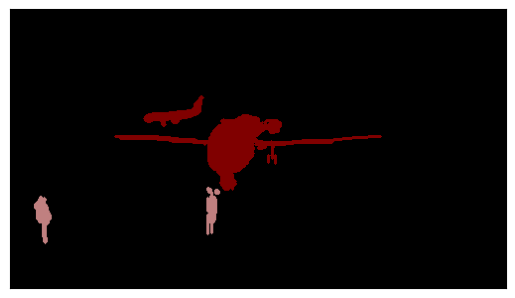

In [ ]:
mask0 = np.array(target0, dtype=np.float32)
mask0_rgb = mask_to_rgb(mask0)
fig, ax = plt.subplots(1, 1)
ax.imshow(mask0_rgb)
ax.set(xticks=[], yticks=[]);

La siguiente función implementa una visualización comparativa entre imagen original, máscara verdadera y máscara predicha por el modelo DeepLabV3

In [ ]:
def display_masks(image, target, prediction):
  if not isinstance(image, list):
    image = [image]
    target = [target]
    prediction = [prediction]

  if not len(image) == len(target) == len(prediction):
    raise ValueError("Mismatch in the number of elements")

  for i in range(len(image)):
    fig, ax = plt.subplots(1, 3, figsize=(16,9))

    ax[0].imshow(image[i].astype(int))
    ax[0].set(title="Original image", xticks=[], yticks=[])

    ax[1].imshow(mask_to_rgb(target[i]))
    ax[2].imshow(mask_to_rgb(prediction[i]))

    ax[1].set(title="Ground Truth", xticks=[], yticks=[])
    ax[2].set(title="Prediction", xticks=[], yticks=[]);

In [ ]:
original_image0, true_mask0, predicted_mask0 = predictSample(np.array(img0, dtype=np.float32),
                                                            np.array(target0, dtype=np.float32),
                                                            Atransform=transform_A)

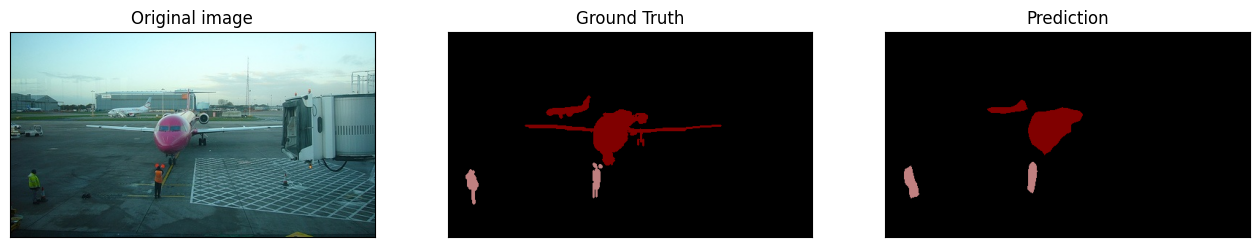

In [ ]:
display_masks(original_image0, true_mask0, predicted_mask0)

In [ ]:
images = []
predictions = []
targets = []
for i in range(1,6):
  img, target = voc_dataset[i]
  original_image, true_mask, predicted_mask = predictSample(np.array(img, dtype=np.float32),
                                                            np.array(target, dtype=np.float32),
                                                            Atransform=transform_A)
  images.append(original_image)
  predictions.append(predicted_mask)
  targets.append(true_mask)

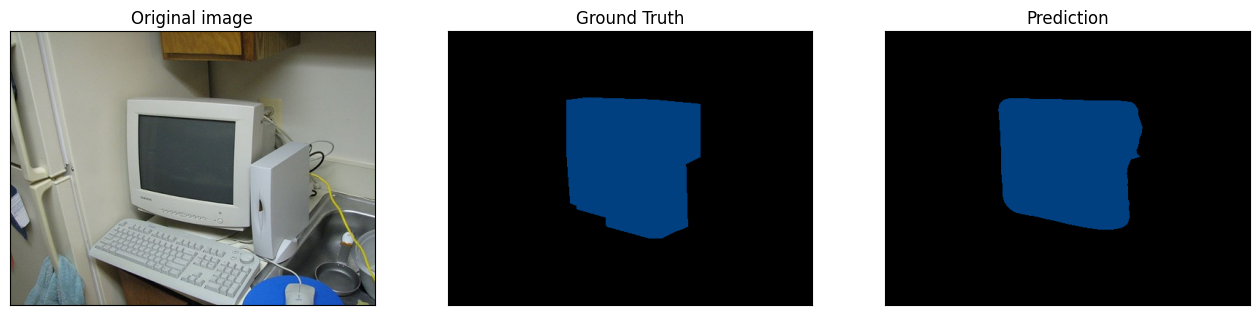

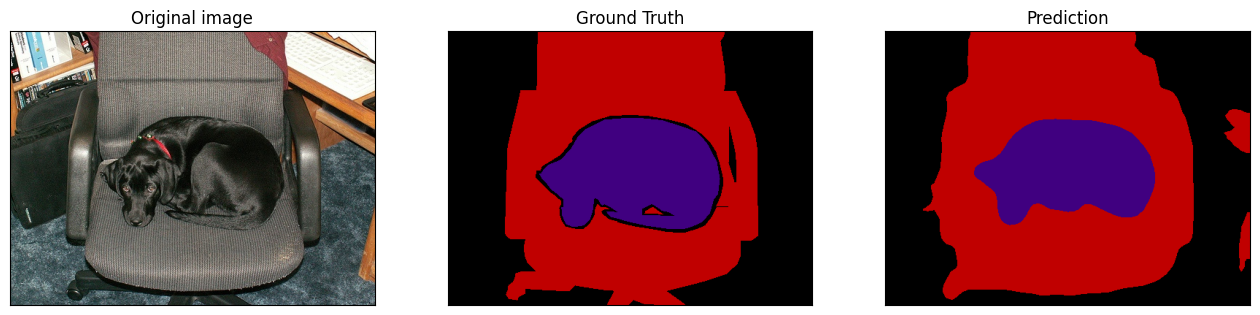

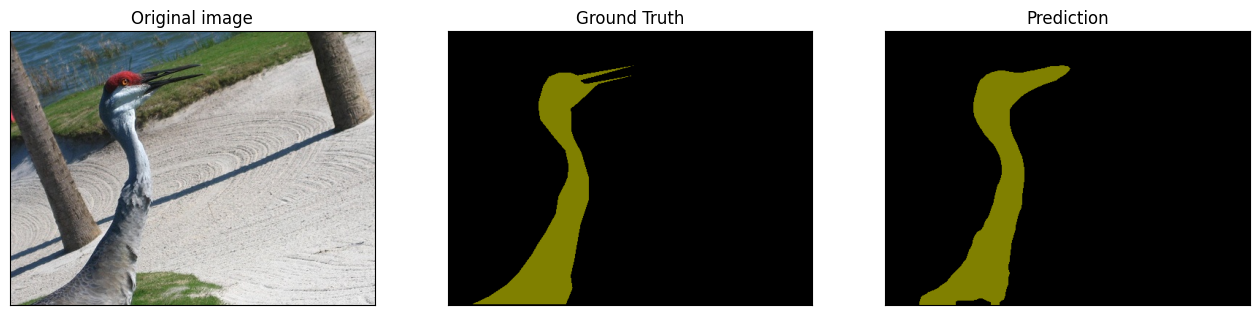

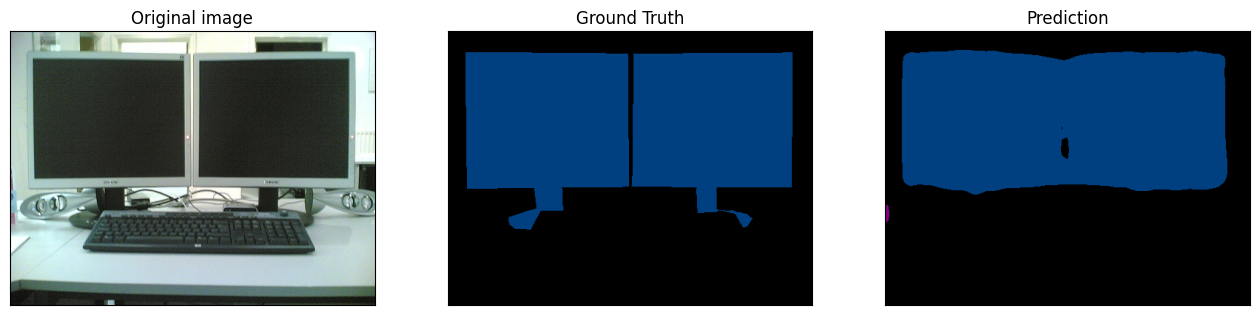

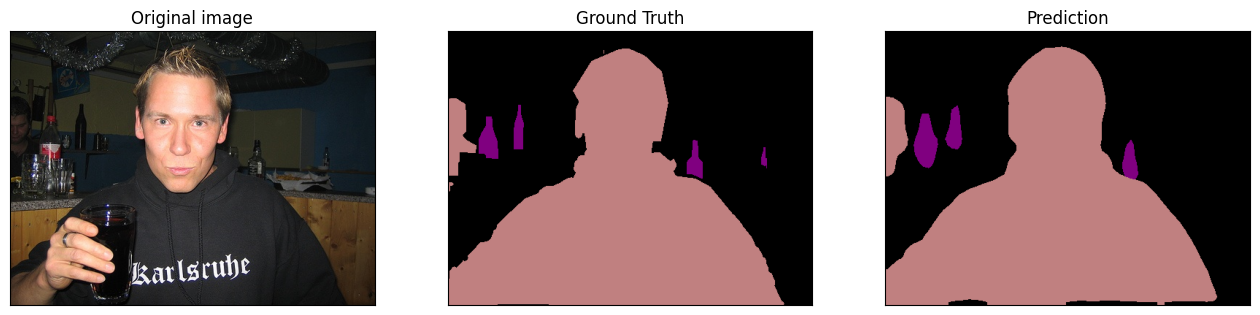

In [ ]:
display_masks(images, targets, predictions)